<a href="https://colab.research.google.com/github/mersalas/MLBS-2025_workshop/blob/main/Lab_1a_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import packages**

In [ ]:
# Install packages
!pip install pca
!pip install scikit-optimize

In [ ]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pca import pca
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.plots import plot_objective
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, auc, roc_auc_score, matthews_corrcoef, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve

## **Load dataset**

In [ ]:
# Fetch dataset
from sklearn.datasets import load_breast_cancer # cancer dataset from sklearn
cancer = load_breast_cancer()

## **Exploratory data analysis**

In [ ]:
#cancer
#features = cancer.data
#target = cancer.target

In [ ]:
# Transform dataset into dataframe
cancer_df = pd.DataFrame(data = np.c_[cancer['data'], cancer['target']],
                         columns = np.append(cancer['feature_names'], ['target']))

In [ ]:
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


In [ ]:
# Know what each features mean
print("cancer.DESCR:\n{}".format(cancer.DESCR))

cancer.DESCR:
.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 features.  For instance, field 0 is Mean Radius, field
    10 is Radius SE, field 20 is Worst R

In [ ]:
# dimensions (rows, columns) or (samples, features+target)
cancer_df.shape

(569, 31)

In [ ]:
# data types
cancer_df.dtypes

,0
mean radius,float64
mean texture,float64
mean perimeter,float64
mean area,float64
mean smoothness,float64
mean compactness,float64
mean concavity,float64
mean concave points,float64
mean symmetry,float64
mean fractal dimension,float64


In [ ]:
# Check missing values
cancer_df.isnull().sum()

,0
mean radius,0
mean texture,0
mean perimeter,0
mean area,0
mean smoothness,0
mean compactness,0
mean concavity,0
mean concave points,0
mean symmetry,0
mean fractal dimension,0


In [ ]:
# Count malignant & benign
cancer_df['target'].value_counts()

,count
target,
1.0,357
0.0,212


In [ ]:
# Look at 4 features at a time
select_columns = ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'target']
cancer_dataset_group1 = pd.DataFrame(cancer_df, columns=select_columns)
cancer_dataset_group1.head()

,mean radius,mean texture,mean perimeter,mean area,target
0,17.99,10.38,122.80,1001.0,0.0
1,20.57,17.77,132.90,1326.0,0.0
2,19.69,21.25,130.00,1203.0,0.0
3,11.42,20.38,77.58,386.1,0.0
4,20.29,14.34,135.10,1297.0,0.0


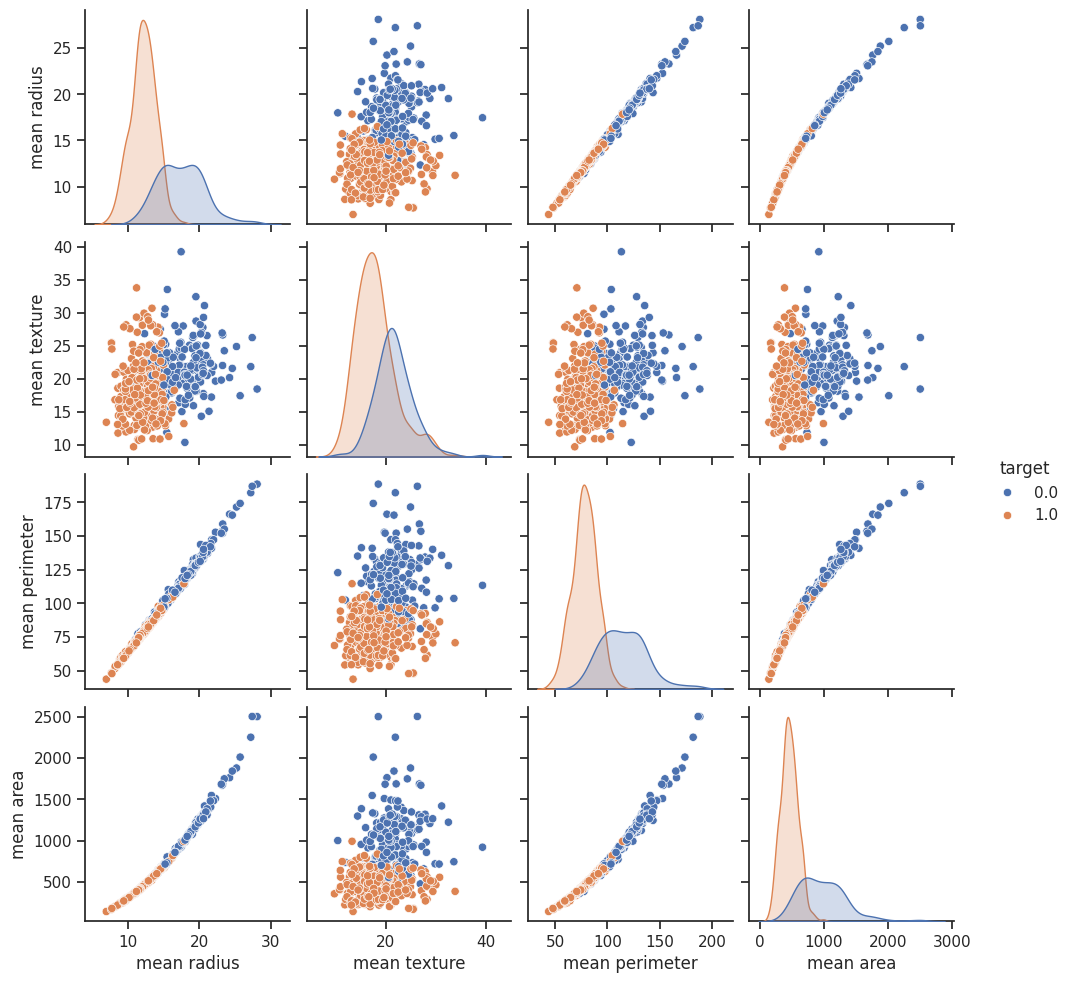

In [ ]:
# Plot pairwise relationship
sns.set(style="ticks")
df = cancer_dataset_group1
sns.pairplot(df, hue="target")

In [ ]:
# Separating the features from the target
X = cancer_df.iloc[:,0:30].values
y = cancer_df['target'].values

### PCA

In [ ]:
# Initialize pca
model = pca(n_components=0.95, normalize=True)

# Fit transform
results = model.fit_transform(X)

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [30] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [30] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[10]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


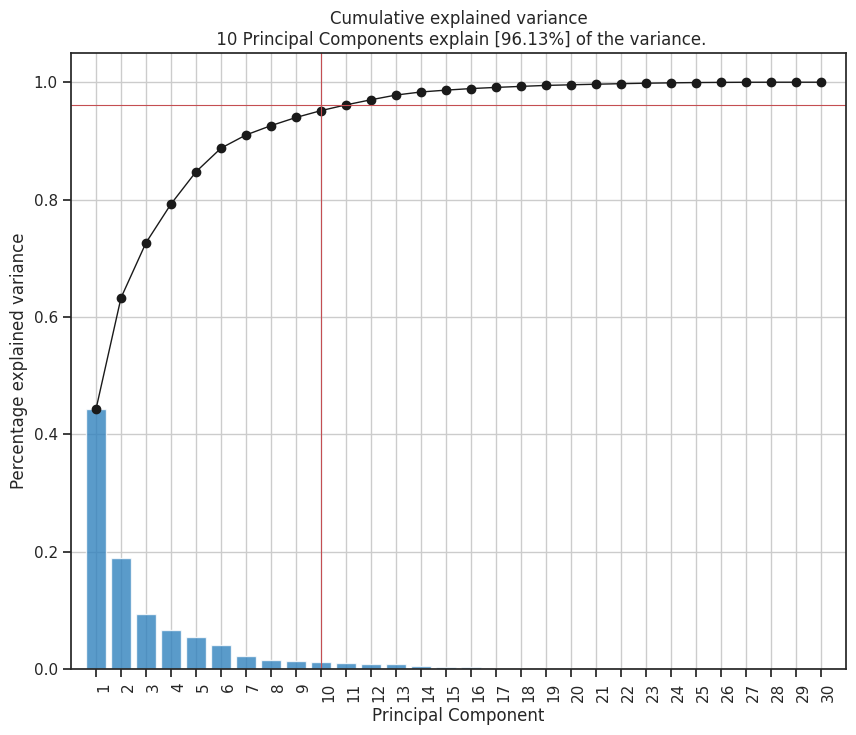

In [ ]:
# Screen plot
model.plot(figsize=(10,8))
plt.show()

In [ ]:
# Print the top features
top = model.results['topfeat']
best = top.loc[top['type']=='best']
best

,PC,feature,loading,type
0,PC1,8,0.260854,best
1,PC2,10,0.366575,best
2,PC3,12,0.374634,best
3,PC4,22,0.632808,best
4,PC5,5,0.365089,best
5,PC6,29,0.498927,best
6,PC7,30,0.374658,best
7,PC8,15,0.573410,best
8,PC9,17,0.358107,best
9,PC10,9,0.572069,best


[scatterd] >INFO> Create scatterplot


[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


(<Figure size 4500x3000 with 1 Axes>,
 <Axes: title={'center': '10 Principal Components explain [96.13%] of the variance'}, xlabel='PC1 (44.2% expl.var)', ylabel='PC2 (18.9% expl.var)'>)

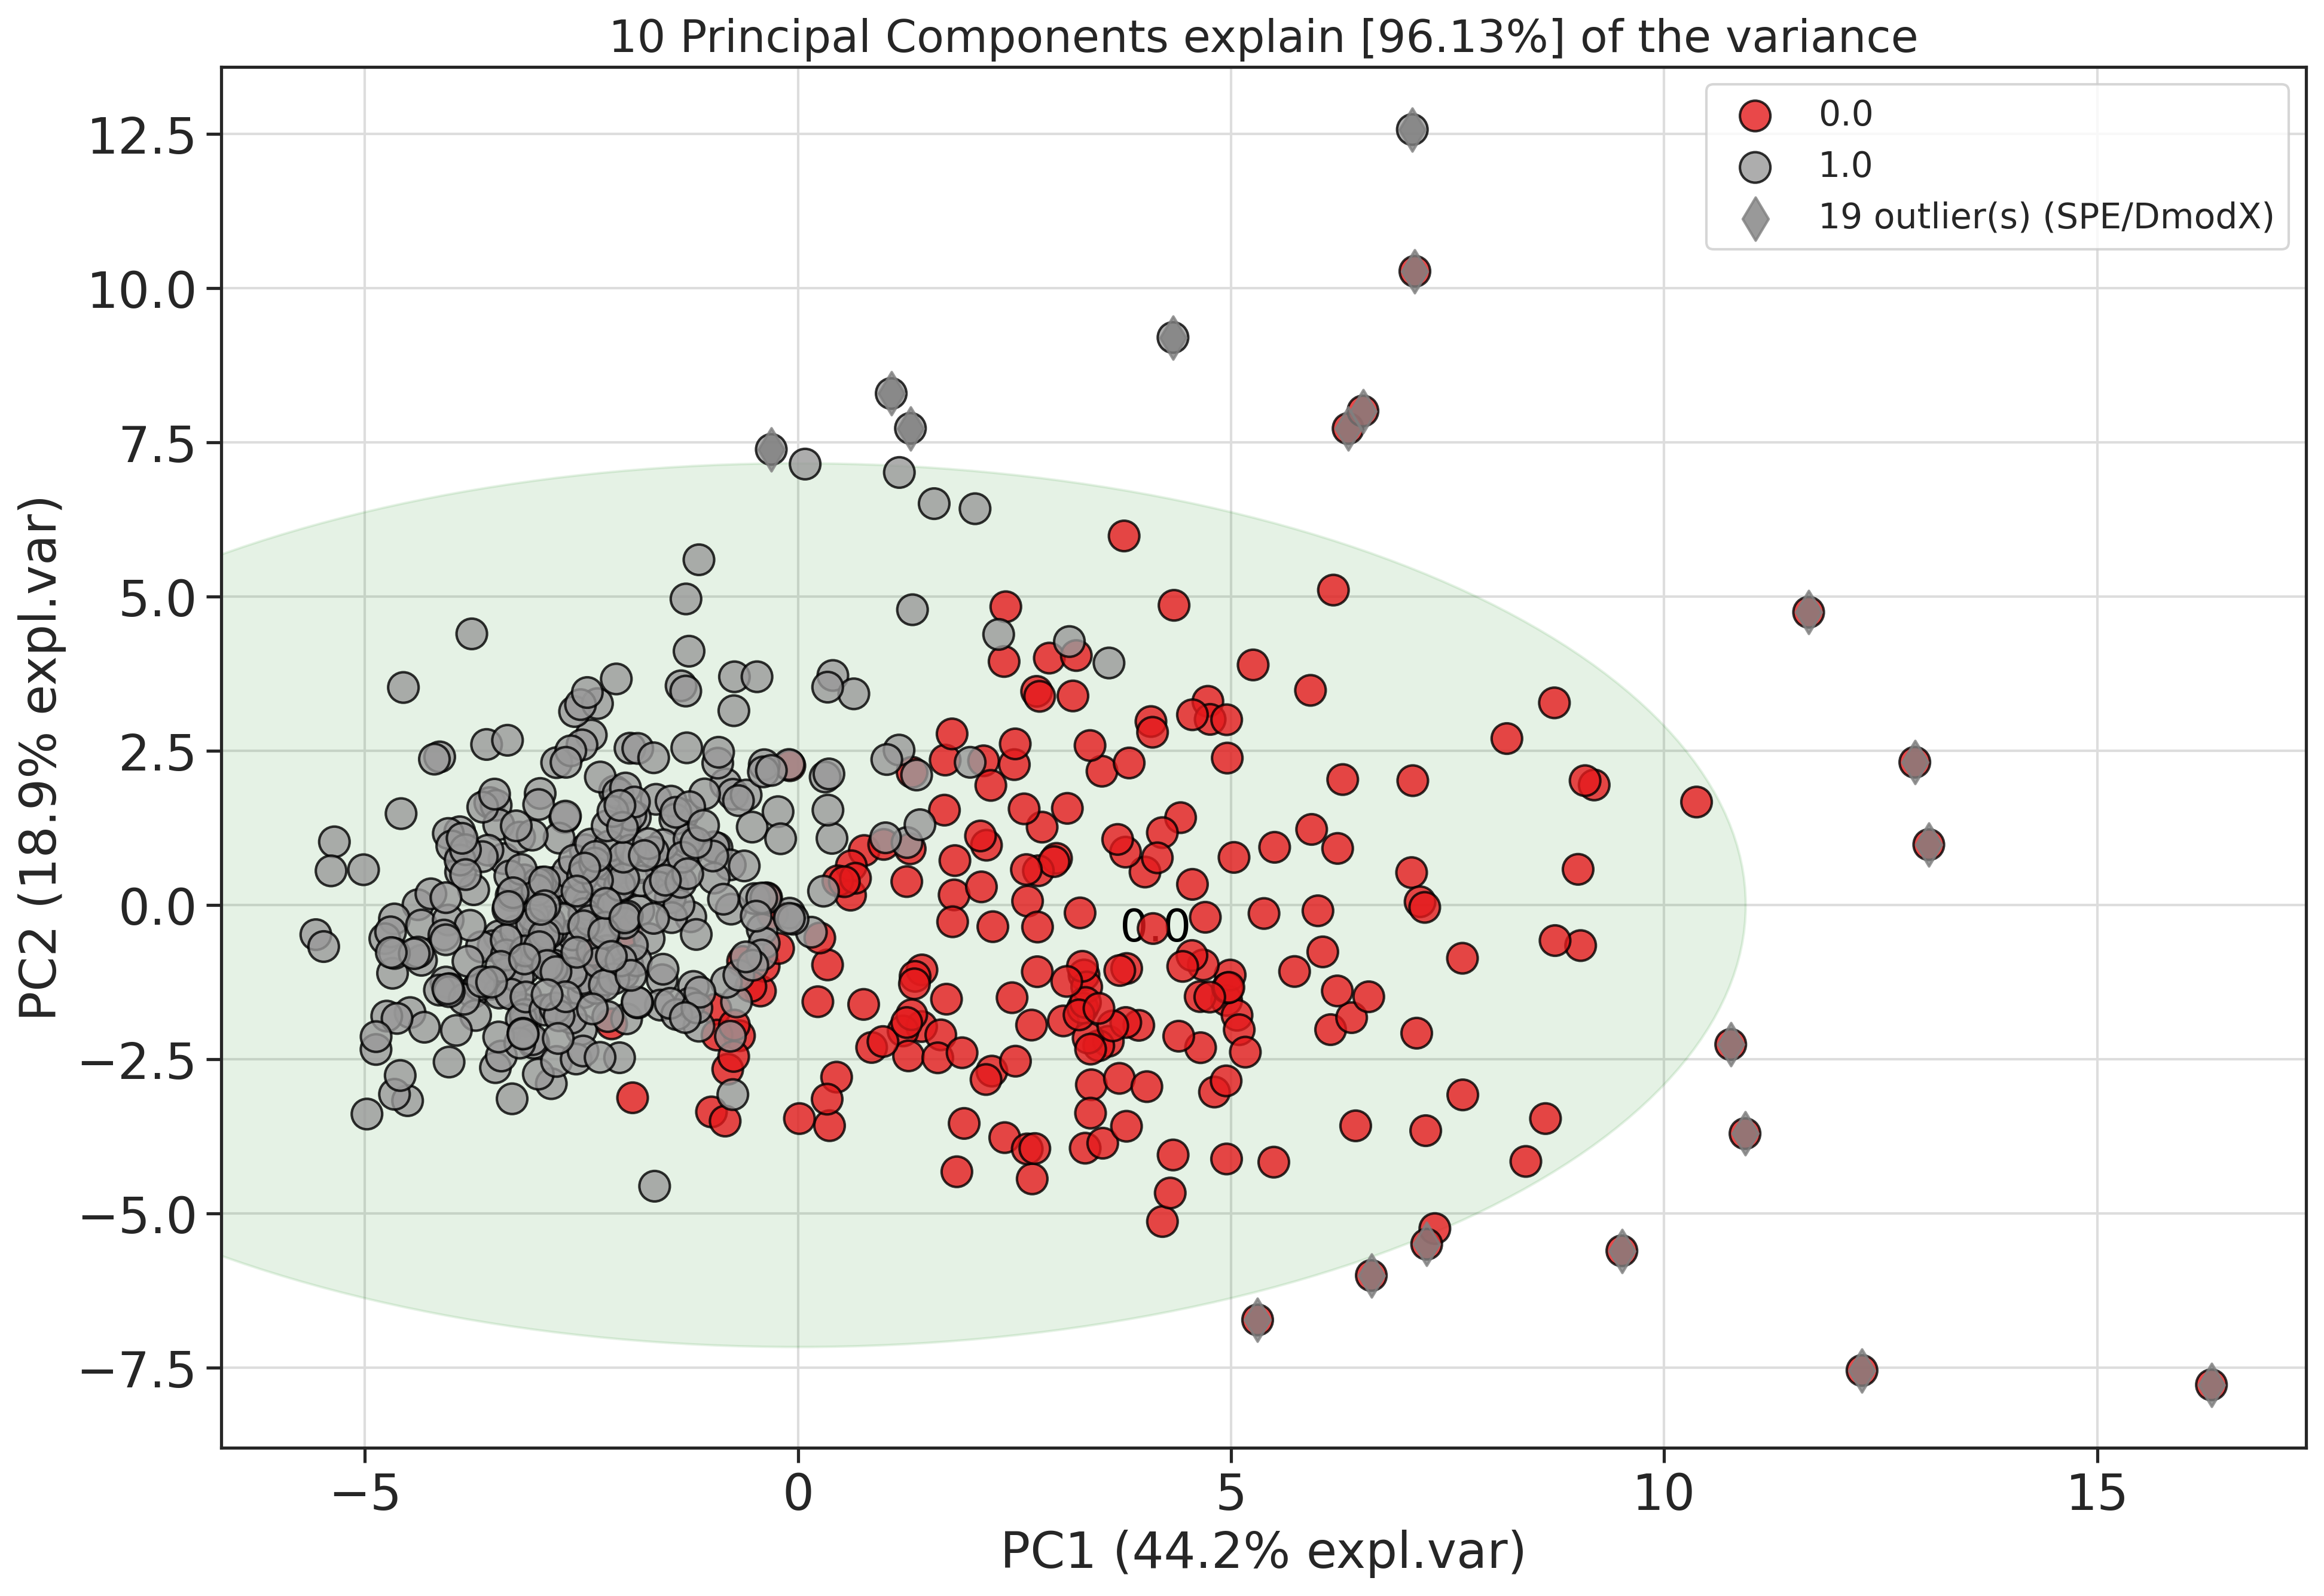

In [ ]:
# 2D scatter plot
model.scatter(labels=y, SPE=True, legend=True, cmap='Set1', figsize=(15,10), dpi=300)

### **Data pre-processing**

In [ ]:
# Normalize the data
norm = StandardScaler()
X_norm = norm.fit_transform(X)

In [ ]:
# Split dataset into training & test set
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.20, stratify=y,
                                                    random_state=42)

print("Size of training set: {}   Size of test set:"
      " {}\n".format(X_train.shape[0], X_test.shape[0]))

Size of training set: 455   SIZE OF TEST SET: 114



## **Train model**

### **Logit**

In [ ]:
# Perform grid search to find optimum parameters for logit
logit = LogisticRegression(max_iter=5000, random_state=42)
param = {'C': np.logspace(-3,3,10)}
logit_cv = GridSearchCV(logit, param, cv=10, n_jobs=-1)
logit_cv.fit(X_train, y_train)

print('best parameters: ', logit_cv.best_params_)
print('best score afetr grid search cv: ', logit_cv.best_score_)

best parameters:  {'C': np.float64(0.1)}
best score afetr grid search cv:  0.9802898550724638


In [ ]:
# Train logit
logit_tuned = LogisticRegression(**logit_cv.best_params_, max_iter=5000, n_jobs=-1,
                                 random_state=42)

logit_tuned.fit(X_train, y_train)

LogisticRegression(C=np.float64(0.1), max_iter=5000, n_jobs=-1, random_state=42)

In [ ]:
# Print intercept & coefficients
print('intercept:', logit_tuned.intercept_ )
print('coef:', logit_tuned.coef_, end='\n')

intercept: [0.42881283]
coef: [[-0.40315842 -0.43890966 -0.38922088 -0.37719322 -0.18966779 -0.00300516
  -0.30218168 -0.40923232 -0.15032411  0.21675909 -0.447415    0.03991508
  -0.3210812  -0.35443066 -0.0441228   0.22716503  0.08320225 -0.18330438
   0.15605177  0.22862951 -0.50989799 -0.55400912 -0.46589869 -0.45331511
  -0.36591129 -0.14438941 -0.36007231 -0.50833107 -0.41218739 -0.11110195]]


In [ ]:
# Evaluate the logit model on the training set
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'matthews_corrcoef']
cv_results = cross_validate(logit_tuned, X_train, y_train, cv=10, scoring=scoring, n_jobs=-1)

print("Performance of the logit model on the training set:\nAcc: {:.4f}\nPr: {:.4f}\nSn: {:.4f}\nF1: {:.4f}\nMCC: {:.4f}\nAUROC: {:.4f}".format(
    np.mean(cv_results['test_accuracy']),
    np.mean(cv_results['test_precision']),
    np.mean(cv_results['test_recall']),
    np.mean(cv_results['test_f1']),
    np.mean(cv_results['test_matthews_corrcoef']),
    np.mean(cv_results['test_roc_auc'])
))

Performance of the logit model on the training set:
Acc: 0.9803
Pr: 0.9736
Sn: 0.9966
F1: 0.9847
MCC: 0.9583
AUROC: 0.9941


### **KNN**

In [ ]:
# Perform random search to find the optimum parameters for KNN
knn = KNeighborsClassifier()
param = {'n_neighbors': range(5, 20), 'weights': ['uniform', 'distance'],
         'metric': ['minkowski', 'manhattan', 'euclidean']}
knn_cv = RandomizedSearchCV(knn, param, cv=10, n_jobs=-1, random_state=42)
knn_cv.fit(X_train, y_train)

print('best parameters: ', knn_cv.best_params_)
print('best score after random search cv:', knn_cv.best_score_)

best parameters:  {'weights': 'distance', 'n_neighbors': 7, 'metric': 'euclidean'}
best score after random search cv: 0.973719806763285


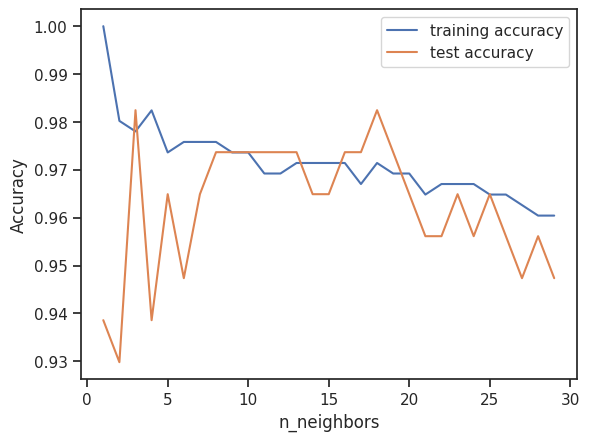

In [ ]:
# Find the optimum k
train_acc = []
test_acc = []

# try n_neighbors from 1 to 30
neighbors_settings = range(1,30)

for n_neighbors in neighbors_settings:
  # build the model
  knn = KNeighborsClassifier(n_neighbors=n_neighbors)
  knn.fit(X_train, y_train)

  # record training set accuracy
  train_acc.append(knn.score(X_train, y_train))

  # record generalization accuracy
  test_acc.append(knn.score(X_test, y_test))

plt.plot(neighbors_settings, train_acc, label="training accuracy")
plt.plot(neighbors_settings, test_acc, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

In [ ]:
# Train KNN
knn_tuned = KNeighborsClassifier(n_neighbors=7, weights='distance', p=2,
                                 metric='euclidean', n_jobs=-1)

knn_tuned.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', n_jobs=-1, n_neighbors=7,
                     weights='distance')

In [ ]:
# Evaluate the KNN model on the training set
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'matthews_corrcoef']
cv_results = cross_validate(knn_tuned, X_train, y_train, cv=10, scoring=scoring, n_jobs=-1)

print("Performance of the KNN model on the training set:\nAcc: {:.4f}\nPr: {:.4f}\nSn: {:.4f}\nF1: {:.4f}\nMCC: {:.4f}\nAUROC: {:.4f}".format(
    np.mean(cv_results['test_accuracy']),
    np.mean(cv_results['test_precision']),
    np.mean(cv_results['test_recall']),
    np.mean(cv_results['test_f1']),
    np.mean(cv_results['test_matthews_corrcoef']),
    np.mean(cv_results['test_roc_auc'])
))

Performance of the KNN model on the training set:
Acc: 0.9737
Pr: 0.9701
Sn: 0.9895
F1: 0.9794
MCC: 0.9447
AUROC: 0.9861


### **SVC**

In [ ]:
# Perform Bayesian search to find optimum parameters for SVC
svc = SVC(random_state=42, kernel='rbf')

param = {'C': (1e-3, 1e1, 'log-uniform'),
         'gamma': (1e-3,1, 'log-uniform')}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
svc_cv = BayesSearchCV(estimator=svc, search_spaces=param, cv=cv, scoring='roc_auc',
                       n_jobs=-1, random_state=42)
svc_cv.fit(X_train, y_train)

print('best parameters: ', svc_cv.best_params_)
print('best score after search cv:', svc_cv.best_score_)

best parameters:  OrderedDict([('C', 3.1873215627895366), ('gamma', 0.02760411818200016)])
best score after search cv: 0.9959214720370907


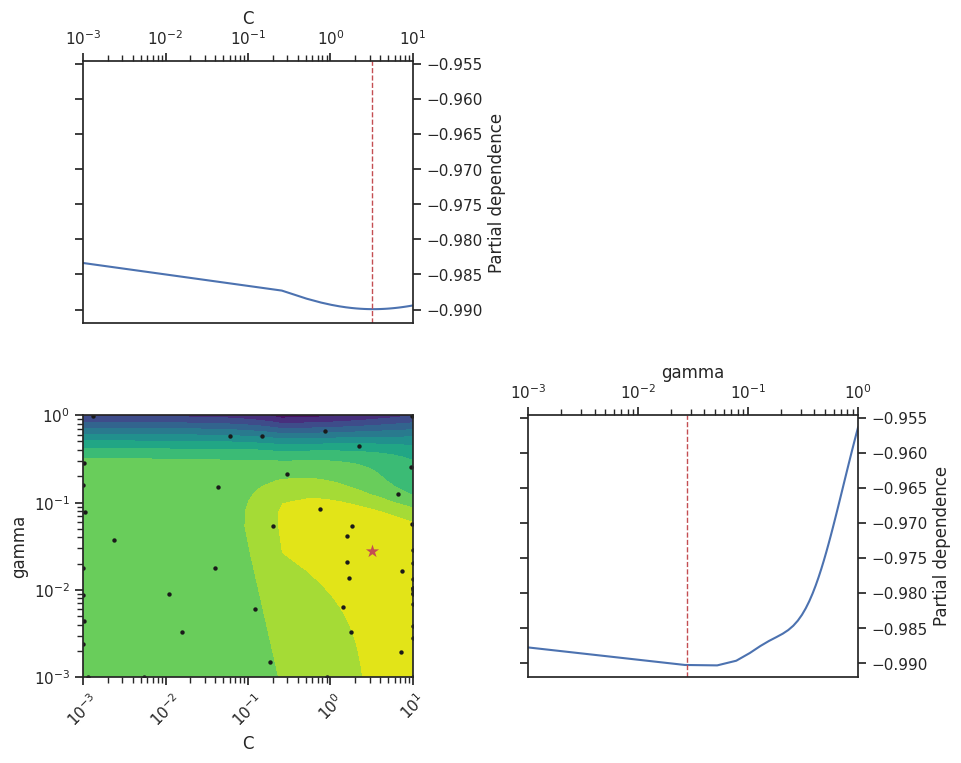

In [ ]:
# Plot the Bayesian objective function
fig, ax = plt.subplots(figsize=(10,8))
plot_objective(svc_cv.optimizer_results_[0], ax=ax)
plt.show()

In [ ]:
# Train SVC
svc_tuned = SVC(kernel='rbf', **svc_cv.best_params_, probability=True, random_state=42)

svc_tuned.fit(X_train, y_train)

SVC(C=3.1873215627895366, gamma=0.02760411818200016, probability=True,
    random_state=42)

In [ ]:
# Evaluate the SVC model on the training set
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'matthews_corrcoef']
cv_results = cross_validate(svc_tuned, X_train, y_train, cv=10, scoring=scoring, n_jobs=-1)

print("Performance of the SVC model on the training set:\nAcc: {:.4f}\nPr: {:.4f}\nSn: {:.4f}\nF1: {:.4f}\nMCC: {:.4f}\nAUROC: {:.4f}".format(
    np.mean(cv_results['test_accuracy']),
    np.mean(cv_results['test_precision']),
    np.mean(cv_results['test_recall']),
    np.mean(cv_results['test_f1']),
    np.mean(cv_results['test_matthews_corrcoef']),
    np.mean(cv_results['test_roc_auc'])
))

Performance of the SVC model on the training set:
Acc: 0.9716
Pr: 0.9770
Sn: 0.9792
F1: 0.9777
MCC: 0.9399
AUROC: 0.9961


## **Evaluation**

### **PR curves**

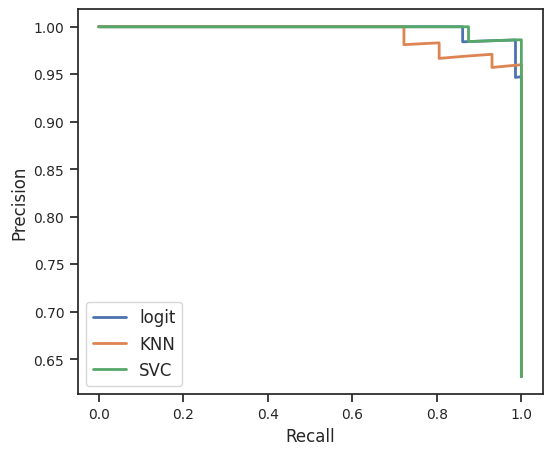

In [ ]:
# Calculate decision function or probabilities for each model
y_thres_logit = logit_tuned.decision_function(X_test)
y_proba_knn = knn_tuned.predict_proba(X_test)[:, 1]
y_thres_svc = svc_tuned.decision_function(X_test)

# Calculate precision & recall for each model
precision_logit, recall_logit, _ = precision_recall_curve(y_test, y_thres_logit)
precision_knn, recall_knn, _ = precision_recall_curve(y_test, y_proba_knn)
precision_svc, recall_svc, _ = precision_recall_curve(y_test, y_thres_svc)

# Function to plot precision-recall curve
def plot_PR_curve(precision, recall, label=None):
  plt.plot(recall, precision, linewidth=2, label=label)
  plt.xticks(fontsize=10)
  plt.yticks(fontsize=10)
  plt.ylabel('Precision', fontsize=12)
  plt.xlabel('Recall', fontsize=12)
  plt.grid(False)

# Plot PR curves for all models
plt.figure(figsize=(6,5))
plot_PR_curve(precision_logit, recall_logit, "logit")
plot_PR_curve(precision_knn, recall_knn, "KNN")
plot_PR_curve(precision_svc, recall_svc, "SVC")

plt.legend(loc="best", fontsize=12)
plt.show()

### **ROC curves**

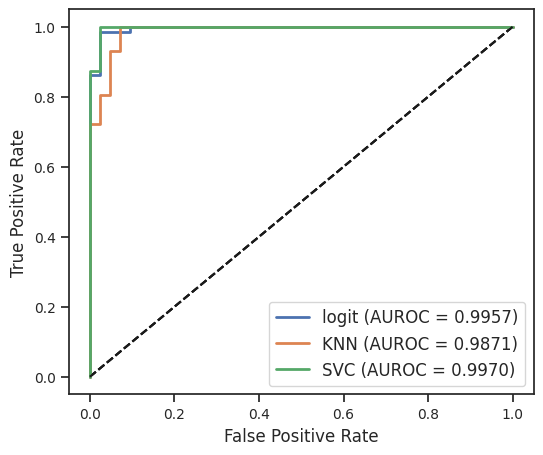

In [ ]:
# Calculate ROC curves and AUC for each model
fpr, tpr, thresholds = roc_curve(y_test, y_thres_logit)
auroc = auc(fpr, tpr)

fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_proba_knn)
auroc_knn = auc(fpr_knn, tpr_knn)

fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, y_thres_svc)
auroc_svc = auc(fpr_svc, tpr_svc)

# Defin a function to plot the ROC curve
def plot_roc_curve(fpr, tpr, auroc, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=f'{label} (AUROC = {auroc:.4f})')
  plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
  plt.xticks(fontsize=10)
  plt.yticks(fontsize=10)
  plt.ylabel('True Positive Rate', fontsize=12)
  plt.xlabel('False Positive Rate', fontsize=12)
  plt.grid(False)

# Plot all ROC curves
plt.figure(figsize=(6,5))
plot_roc_curve(fpr, tpr, auroc, "logit")
plot_roc_curve(fpr_knn, tpr_knn, auroc_knn, "KNN")
plot_roc_curve(fpr_svc, tpr_svc, auroc_svc, "SVC")

plt.legend(loc="best", fontsize=12)
plt.savefig('ROC.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Evaluate the SVC model on the test set
y_pred_svc = svc_tuned.predict(X_test)
y_proba_svc = svc_tuned.predict_proba(X_test)[:, 1]

print("Performance of the SVC model on the test set:")
print("Acc: {:.4f}".format(accuracy_score(y_test, y_pred_svc)))
print("Pr: {:.4f}".format(precision_score(y_test, y_pred_svc)))
print("Sn: {:.4f}".format(recall_score(y_test, y_pred_svc)))
print("F1: {:.4f}".format(f1_score(y_test, y_pred_svc)))
print("MCC: {:.4f}".format(matthews_corrcoef(y_test, y_pred_svc)))
print("AUROC: {:.4f}".format(roc_auc_score(y_test, y_proba_svc)))

Performance of the SVC model on the test set:
Acc: 0.9737
Pr: 0.9859
Sn: 0.9722
F1: 0.9790
MCC: 0.9439
AUROC: 0.9970


In [ ]:
# Print classification report for svc
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96        42
         1.0       0.99      0.97      0.98        72

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



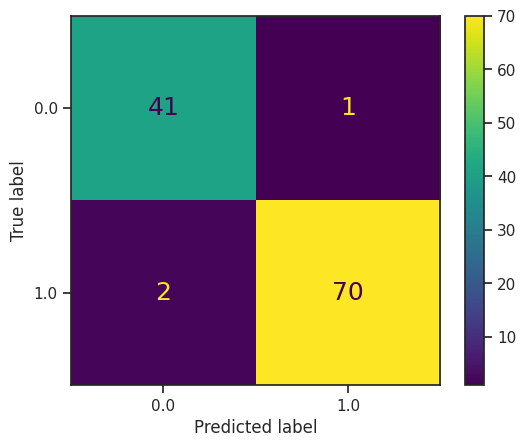

In [ ]:
# Plot confusion matrix for svc model
cm = confusion_matrix(y_test, y_pred_svc, labels=svc_tuned.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc_tuned.classes_)
disp.plot()

### **Extract best features**

In [ ]:
# Convert the feature‑position strings to integer indices
best_indices = best['feature'].astype(int).tolist()
print("Best feature positions:", best_indices)

# Map those indices to the real column names in cancer_df
best_feature_names = cancer_df.columns[best_indices].tolist()
print("Best feature names:", best_feature_names)

Best feature positions: [8, 10, 12, 22, 5, 29, 30, 15, 17, 9]
Best feature names: ['mean symmetry', 'radius error', 'perimeter error', 'worst perimeter', 'mean compactness', 'worst fractal dimension', 'target', 'compactness error', 'concave points error', 'mean fractal dimension']


In [ ]:
# Subset cancer_df by those column names
X_select = cancer_df[best_feature_names]
X_select

,mean symmetry,radius error,perimeter error,worst perimeter,mean compactness,worst fractal dimension,target,compactness error,concave points error,mean fractal dimension
0,0.2419,1.0950,8.589,184.60,0.27760,0.11890,0.0,0.04904,0.01587,0.07871
1,0.1812,0.5435,3.398,158.80,0.07864,0.08902,0.0,0.01308,0.01340,0.05667
2,0.2069,0.7456,4.585,152.50,0.15990,0.08758,0.0,0.04006,0.02058,0.05999
3,0.2597,0.4956,3.445,98.87,0.28390,0.17300,0.0,0.07458,0.01867,0.09744
4,0.1809,0.7572,5.438,152.20,0.13280,0.07678,0.0,0.02461,0.01885,0.05883
...,...,...,...,...,...,...,...,...,...,...
564,0.1726,1.1760,7.673,166.10,0.11590,0.07115,0.0,0.02891,0.02454,0.05623
565,0.1752,0.7655,5.203,155.00,0.10340,0.06637,0.0,0.02423,0.01678,0.05533
566,0.1590,0.4564,3.425,126.70,0.10230,0.07820,0.0,0.03731,0.01557,0.05648
567,0.2397,0.7260,5.772,184.60,0.27700,0.12400,0.0,0.06158,0.01664,0.07016


In [ ]:
# Save in GDrive
csv_path = '/content/X_select.csv'
X_select.to_csv(csv_path, index=False)

In [ ]:
X_select = pd.read_csv('/content/X_select.csv')
X_select

,mean symmetry,radius error,perimeter error,worst perimeter,mean compactness,worst fractal dimension,target,compactness error,concave points error,mean fractal dimension
0,0.2419,1.0950,8.589,184.60,0.27760,0.11890,0.0,0.04904,0.01587,0.07871
1,0.1812,0.5435,3.398,158.80,0.07864,0.08902,0.0,0.01308,0.01340,0.05667
2,0.2069,0.7456,4.585,152.50,0.15990,0.08758,0.0,0.04006,0.02058,0.05999
3,0.2597,0.4956,3.445,98.87,0.28390,0.17300,0.0,0.07458,0.01867,0.09744
4,0.1809,0.7572,5.438,152.20,0.13280,0.07678,0.0,0.02461,0.01885,0.05883
...,...,...,...,...,...,...,...,...,...,...
564,0.1726,1.1760,7.673,166.10,0.11590,0.07115,0.0,0.02891,0.02454,0.05623
565,0.1752,0.7655,5.203,155.00,0.10340,0.06637,0.0,0.02423,0.01678,0.05533
566,0.1590,0.4564,3.425,126.70,0.10230,0.07820,0.0,0.03731,0.01557,0.05648
567,0.2397,0.7260,5.772,184.60,0.27700,0.12400,0.0,0.06158,0.01664,0.07016


### **Exercise 1a**



*   Perform EDA on X_select dataset
*   Build a random forest classifier for the dataset



